In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import glob
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/2024_TCG_VED/')
from util import derive_var,read_and_proc,ts_models,benchmark
import properscoring as ps
from copy import deepcopy
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})
import random

# Basic Settings

In [32]:
# Setting up seed so that results are reproducible
benchmark.setup_seed(8888)

# Setting up path where things are stored
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'

# Reading u-wind and v-wind to calculate surface intensification (Fig.4c)
path_wnd = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix_wnd = '_smooth_preproc_dict1b_g'

# Pressure level to plot for Fig.4
pressurelevel = [1000,100]
preslv = np.linspace(1000,100,10)
pressure_indx = [np.abs(preslv-obj).argmin() for obj in pressurelevel]

# For radial coordinates -> cartesian conversion
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))

In [4]:
# Read in processed data
storedata,store_notensor,store_axisym,store_minus,store_addasym,store_minusasym,store_axisym_preserve = {},{},{},{},{},{},{}
for i in tqdm(range(0,40)):
    storedata[i] = benchmark.prepare_tensors('../processed/haiyan_store',i,23,'No')
    store_notensor[i] = benchmark.prepare_tensors('../processed/haiyan_store',i,23,'Yes')
    store_axisym_preserve[i] = benchmark.prepare_tensors('../processed/haiyan_store/sensitivity/axisym_preserve',i,23,'Yes')
    store_addasym[i] = benchmark.prepare_tensors('../processed/haiyan_store/sensitivity/asym',i,23,'Yes')
    store_minusasym[i] = benchmark.prepare_tensors('../processed/haiyan_store/sensitivity/minus_asym',i,23,'Yes')
    store_minus[i] = benchmark.prepare_tensors('../processed/haiyan_store/sensitivity/minus_axisym_preserve',i,23,'Yes')

  0%|          | 0/40 [00:00<?, ?it/s]

# Read in model, make predictions, and calculate performance metrics

## VAE

In [5]:
# Basic Settings for the wrapper to get the full model predictions and basic performance metrics
losscoeffs = [0.45,0.55,0.65,0.75,0.85,0.95,1] #lambda term in the loss function
numsplit = 40 #Number of splits we have trained
trailnums = 30 #Multiple iteration of model predictions are saved to get the prediction spread
seeds = np.random.randint(0, 500,size=20) #Choose 20 seeds randomly to run model inference

# Save results in a dictionary
# Performance metrics to be saved: CRPS score; Save prediction spread
seeds_store = {}
for seed in seeds:
    crps_store_vae = {}
    for losscoeff in tqdm(losscoeffs):
        if (losscoeff==1):
            suffix=None
        else:
            suffix='_*best*'
        crps_store_vae[losscoeff] = benchmark.get_performances_vae(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='../processed/haiyan_store/vae/losscoeff_'+str(losscoeff)+'/',suffix=suffix,
                                                                   droprate=None,metric='crps',trailnums=trailnums,withspread=True,output_type='vae',seed=seed)
    seeds_store[seed] = crps_store_vae

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

# Choose the best model

In [8]:
# Get the SSREL score for all the models, with different seeds, split, and initialization
allsave = []
for snumz in tqdm(np.linspace(0,19,20)):
    tmpsave_1 = {}
    for coeffz in losscoeffs:
        tmpsave_2 = []
        for splitnoz in range(39):
            snumz=int(snumz)
            tempsNUM = len(seeds_store[seeds[snumz]][coeffz][splitnoz]['truth'])
            tmpsave_3 = [benchmark.get_spread_skill_score_model(seeds_store=seeds_store,seeds=seeds,snum=snumz,coeff=coeffz,splitno=splitnoz,modelno=i,category='valid',meancat='meanvals') for i in range(tempsNUM)]
            tmpsave_2.append(tmpsave_3)
        tmpsave_1[coeffz] = tmpsave_2
    allsave.append(tmpsave_1)
    
# Save the minimum SSREL score for models with different splits and initialization    
ssRels_array = np.zeros((39,9))
for i in (range(39)):
    for j in (range(9)):
        ssRels_array[i,j] = np.asarray([allsave[k][0.85][i][j]['ssRel'] for k in range(20)]).min()

  0%|          | 0/20 [00:00<?, ?it/s]

In [17]:
# Find the split and initialization that produce the lowest SSREL score
minsplit,minmodel = np.argwhere(ssRels_array == np.min(ssRels_array))[0][0],np.argwhere(ssRels_array == np.min(ssRels_array))[0][1]

# Find the seed number that produces the lowest SSREL score for a given split and initialization
minseed = np.asarray([allsave[k][0.85][minsplit][minmodel]['ssRel'] for k in range(20)]).argmin()

# Benchmark and Plotting

In [22]:
# Read in the best model
bestmodel = seeds_store[seeds[minseed]][0.85][minsplit]['models'][minmodel]

# Calculate the effective weights (see SI for details); -40 and -20 are the indices of the longwave PCs in the input data
ALW = benchmark.analysis_patterns(None,None).new_coeff_vae(store_notensor[minsplit]['train'][0],bestmodel,'LW',[-40,-20])
ASW = benchmark.analysis_patterns(None,None).new_coeff_vae(store_notensor[minsplit]['train'][0],bestmodel,'SW',[-40,-20])

# Calculate the overall bias (see SI for details)
B = benchmark.analysis_patterns(None,None).new_b_vae(store_notensor[minsplit]['train'][0],bestmodel,[-40,-20])

# PCA objects produced by the scikit-learn library
pcalw = read_and_proc.depickle('../processed/haiyan_store/pca/lw/'+str(minsplit)+'/PCA3D.pkg'),read_and_proc.depickle('../processed/haiyan_store/pca/sw/'+str(minsplit)+'/PCA3D.pkg')

# Weights to get the $\Pi_{\mu, LW}$, $\Pi_{\mu, SW}$ structures from the SI equations
fl = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[minsplit]['train'][0],bestmodel,'LW')
flsw = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[minsplit]['train'][0],bestmodel,'SW')

## Figure 2

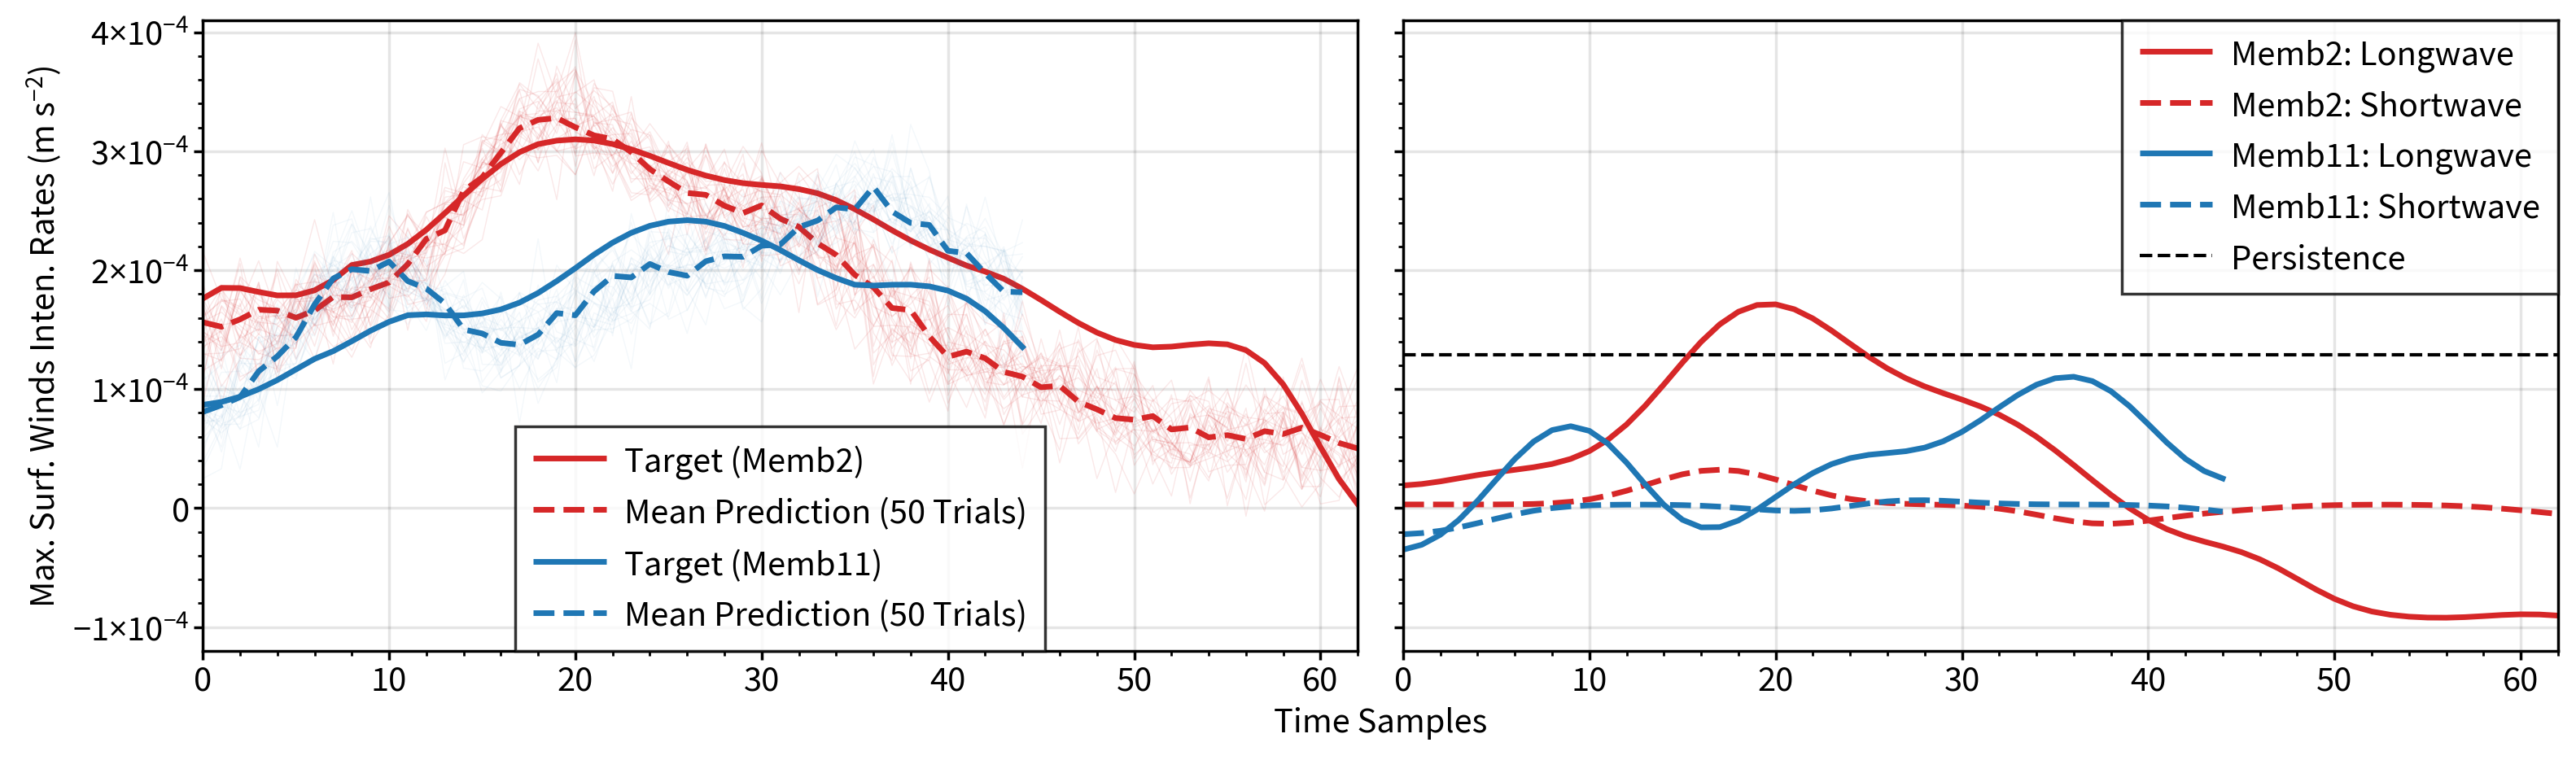

In [23]:
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 16.05,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

accesscode = 0.85
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=7.095,refaspect=1.831,sharey=3)
axs[0].plot(store_notensor[minsplit]['train'][1][132:195],label=f'Target (Memb2)',c='tab:red',lw=2.5)#79:132])
axs[0].plot(seeds_store[seeds[0]][accesscode][int(minsplit)]['meantrains'][int(minmodel)][132:195],label='Mean Prediction (50 Trials)',c='tab:red',lw=2.5,ls='--')#79:132])
allpreds = seeds_store[seeds[0]][accesscode][int(minsplit)]['alltrains'][int(minmodel)]
for pred in allpreds:
    axs[0].plot(pred[132:195],c='tab:red',lw=0.5,alpha=0.105)
    
axs[0].plot(store_notensor[minsplit]['train'][1][610:655],label=f'Target (Memb11)',c='tab:blue',lw=2.5)#79:132])
axs[0].plot(seeds_store[seeds[0]][accesscode][int(minsplit)]['meantrains'][int(minmodel)][610:655],label='Mean Prediction (50 Trials)',c='tab:blue',lw=2.5,ls='--')#79:132])
allpreds = seeds_store[seeds[0]][accesscode][int(minsplit)]['alltrains'][int(minmodel)]
for pred in allpreds:
    axs[0].plot(pred[610:655],c='tab:blue',lw=0.5,alpha=0.05)    
axs[0].legend(loc=1,ncols=1)
axs[0].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates (m s$^{-2}$)')#,ltitle='Haiyan',rtitle=f'Best Model: Train')

axs[1].plot(ALW*np.dot(np.asarray(store_notensor[minsplit]['train'][0])[:,-40:-20],fl)[132:195],label='Memb2: Longwave',c='tab:red',lw=2.5)#79:132])
axs[1].plot(ASW*np.dot(np.asarray(store_notensor[minsplit]['train'][0])[:,-20:],flsw)[132:195],label='Memb2: Shortwave',c='tab:red',lw=2.5,ls='--')
axs[1].plot(ALW*np.dot(np.asarray(store_notensor[minsplit]['train'][0])[:,-40:-20],fl)[610:655],label='Memb11: Longwave',c='tab:blue',lw=2.5)#79:132])
axs[1].plot(ASW*np.dot(np.asarray(store_notensor[minsplit]['train'][0])[:,-20:],flsw)[610:655],label='Memb11: Shortwave',c='tab:blue',lw=2.5,ls='--')
axs[1].axhline(y=B,label='Persistence',c='k',lw=1.5,ls='--')
axs[1].legend(loc=1,ncols=1)
axs[1].format(xlabel='Time Samples',ylabel=r'Max. Surf. Winds Inten. Rates (m s$^{-2}$)',ylim=[-0.00012,0.00041])#,xlim=[10,118-15])
axs[0].yaxis.set_major_formatter(plot.Formatter(('sci')))
#plt.savefig('./figures/paper_fig2_haiyan_revised.png',dpi=600)
plt.show()

## Sensitivity Experiment (Fig 4e)

In [24]:
# Longwave Contribution when adding/subtracting synthetic axisymmetric structure
axisym_a = ALW*np.dot(np.asarray(store_axisym_preserve[minsplit]['train'][0])[:,-40:-20],fl)
axisym_am = ALW*np.dot(np.asarray(store_minus[minsplit]['train'][0])[:,-40:-20],fl)
# Longwave Contribution when adding/subtracting synthetic asymmetric structure
asym_a = ALW*np.dot(np.asarray(store_addasym[minsplit]['train'][0])[:,-40:-20],fl)
asym_am = ALW*np.dot(np.asarray(store_minusasym[minsplit]['train'][0])[:,-40:-20],fl)

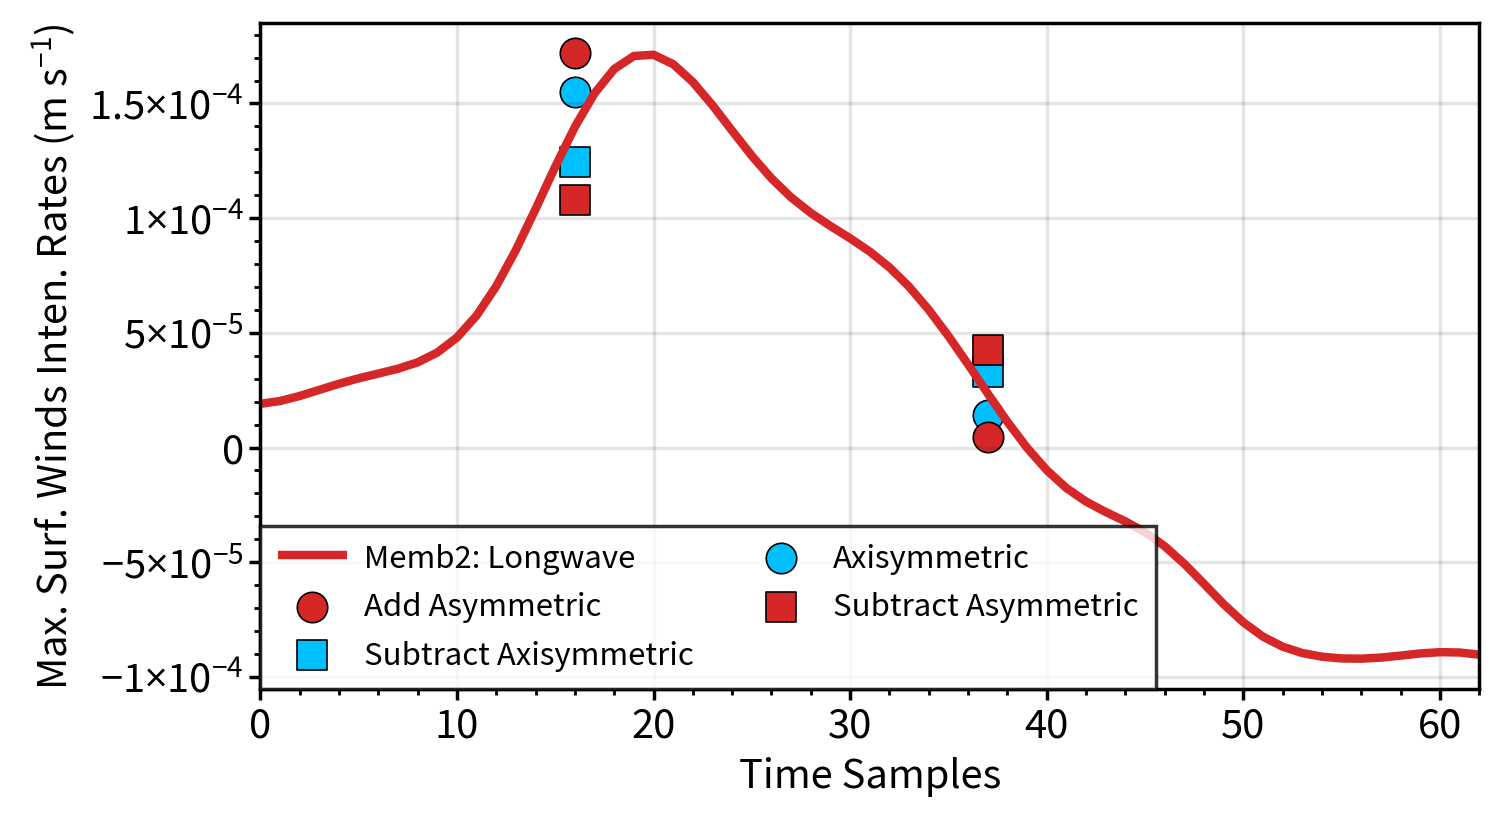

In [26]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=6.095,refaspect=1.831,sharey=3)

# Sensitivity experiment LW contributions for two time samples
axs[0].scatter(16,(axisym_a)[132:195][16],label='Axisymmetric',s=120,edgecolors='k',c='deepskyblue')
axs[0].scatter(16,(asym_a)[132:195][16],label='Add Asymmetric',s=120,edgecolors='k',c='tab:red')
axs[0].scatter(16,(asym_am)[132:195][16],label='Subtract Asymmetric',s=120,edgecolors='k',c='tab:red',marker='s')
axs[0].scatter(16,(axisym_am)[132:195][16],label='Subtract Axisymmetric',s=120,edgecolors='k',c='deepskyblue',marker='s')
axs[0].scatter(37,(axisym_am)[132:195][37],s=120,edgecolors='k',c='deepskyblue',marker='s')
axs[0].scatter(37,(axisym_a)[132:195][37],s=120,edgecolors='k',c='deepskyblue')
axs[0].scatter(37,(asym_a)[132:195][37],s=120,edgecolors='k',c='tab:red')
axs[0].scatter(37,(asym_am)[132:195][37],s=120,edgecolors='k',c='tab:red',marker='s')

# Original LW contribution for comparison
axs[0].plot(ALW*np.dot(np.asarray(store_notensor[minsplit]['train'][0])[:,-40:-20],fl)[132:195],label='Memb2: Longwave',c='tab:red',lw=3.05)
axs[0].format(xlabel='Time Samples',ylabel=r'Max. Surf. Winds Inten. Rates (m s$^{-1}$)')#,xlim=[10,118-15])
axs[0].yaxis.set_major_formatter(plot.Formatter(('sci')))
plt.legend(loc=1,ncols=2,prop={'size':12.5})
#plt.savefig('./figures/SI/paper_fig4_haiyan_perturbinput.png',dpi=600)
plt.show()

# Rest of Figure 4

In [29]:
# Splits and initializations that have the lowest SSREL scores (check ssRels_array)
splitnum=[26,26,26,26,30,19,26,26,29,26]
mdlnum = [8,4,2,0,0,5,3,5,5,7]

# Repeat the steps above, but for the 10 best models
storeLW,storeSW,storeLW_logvar = [],[],[]
storeTS = []
for splitz,mdlnum in zip(splitnum,mdlnum):
    sdnum = np.asarray([allsave[k][accesscode][splitz][mdlnum]['ssRel'] for k in range(20)]).argmin()
    
    # best model
    bestmodel = seeds_store[seeds[sdnum]][accesscode][splitz]['models'][mdlnum]
    
    # PC objects
    pcalw,pcasw = read_and_proc.depickle('../processed/haiyan_store/pca/lw/'+str(splitz)+'/PCA3D.pkg'),read_and_proc.depickle('../processed/haiyan_store/pca/sw/'+str(splitz)+'/PCA3D.pkg')
    
    # weights for mean and log(sigma^2) structures, LW and SW
    fl = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[splitz]['train'][0],bestmodel,'LW')
    flsw = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[splitz]['train'][0],bestmodel,'SW')
    fl_logvar = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[splitz]['train'][0],bestmodel,'LW_logvar')
    fl_swlogvar = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[splitz]['train'][0],bestmodel,'SW_logvar')
    
    # getting the 3D mean and log(sigma^2) structures with the weights
    flas = np.squeeze(np.dot(fl,pcalw['lw'].components_[:20,:])).reshape(10,360,208)
    flas_sw = np.squeeze(np.dot(flsw,pcasw['sw'].components_[:20,:])).reshape(10,360,208)
    flas_lwlogvar = np.squeeze(np.dot(fl_logvar,pcalw['lw'].components_[:20,:])).reshape(10,360,208)
    flas_swlogvar = np.squeeze(np.dot(fl_swlogvar,pcasw['sw'].components_[:20,:])).reshape(10,360,208)
    
    # time evolution of the structures
    TS_lw = np.dot(np.asarray(store_notensor[splitz]['train'][0])[:,-40:-20],fl)
    TS_lwlogvar = np.dot(np.asarray(store_notensor[splitz]['train'][0])[:,-40:-20],fl_logvar)
    TS_sw = np.dot(np.asarray(store_notensor[splitz]['train'][0])[:,-20:],flsw)
    TS_swlogvar = np.dot(np.asarray(store_notensor[splitz]['train'][0])[:,-20:],fl_swlogvar)
    
    # storage
    storeLW.append(flas)
    storeSW.append(flas_sw)
    storeLW_logvar.append(flas_lwlogvar)
    storeTS.append({'lw':TS_lw,'sw':TS_sw,'lw_logvar':TS_lwlogvar,'sw_logvar':TS_swlogvar})

In [31]:
# Reading u-wind and v-wind to calculate surface intensification (Fig.4c)
haiyan_u = [read_and_proc.depickle(path_wnd+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix_wnd)['u'] for lime in tqdm(range(1,21))]
haiyan_v = [read_and_proc.depickle(path_wnd+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix_wnd)['v'] for lime in tqdm(range(1,21))]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

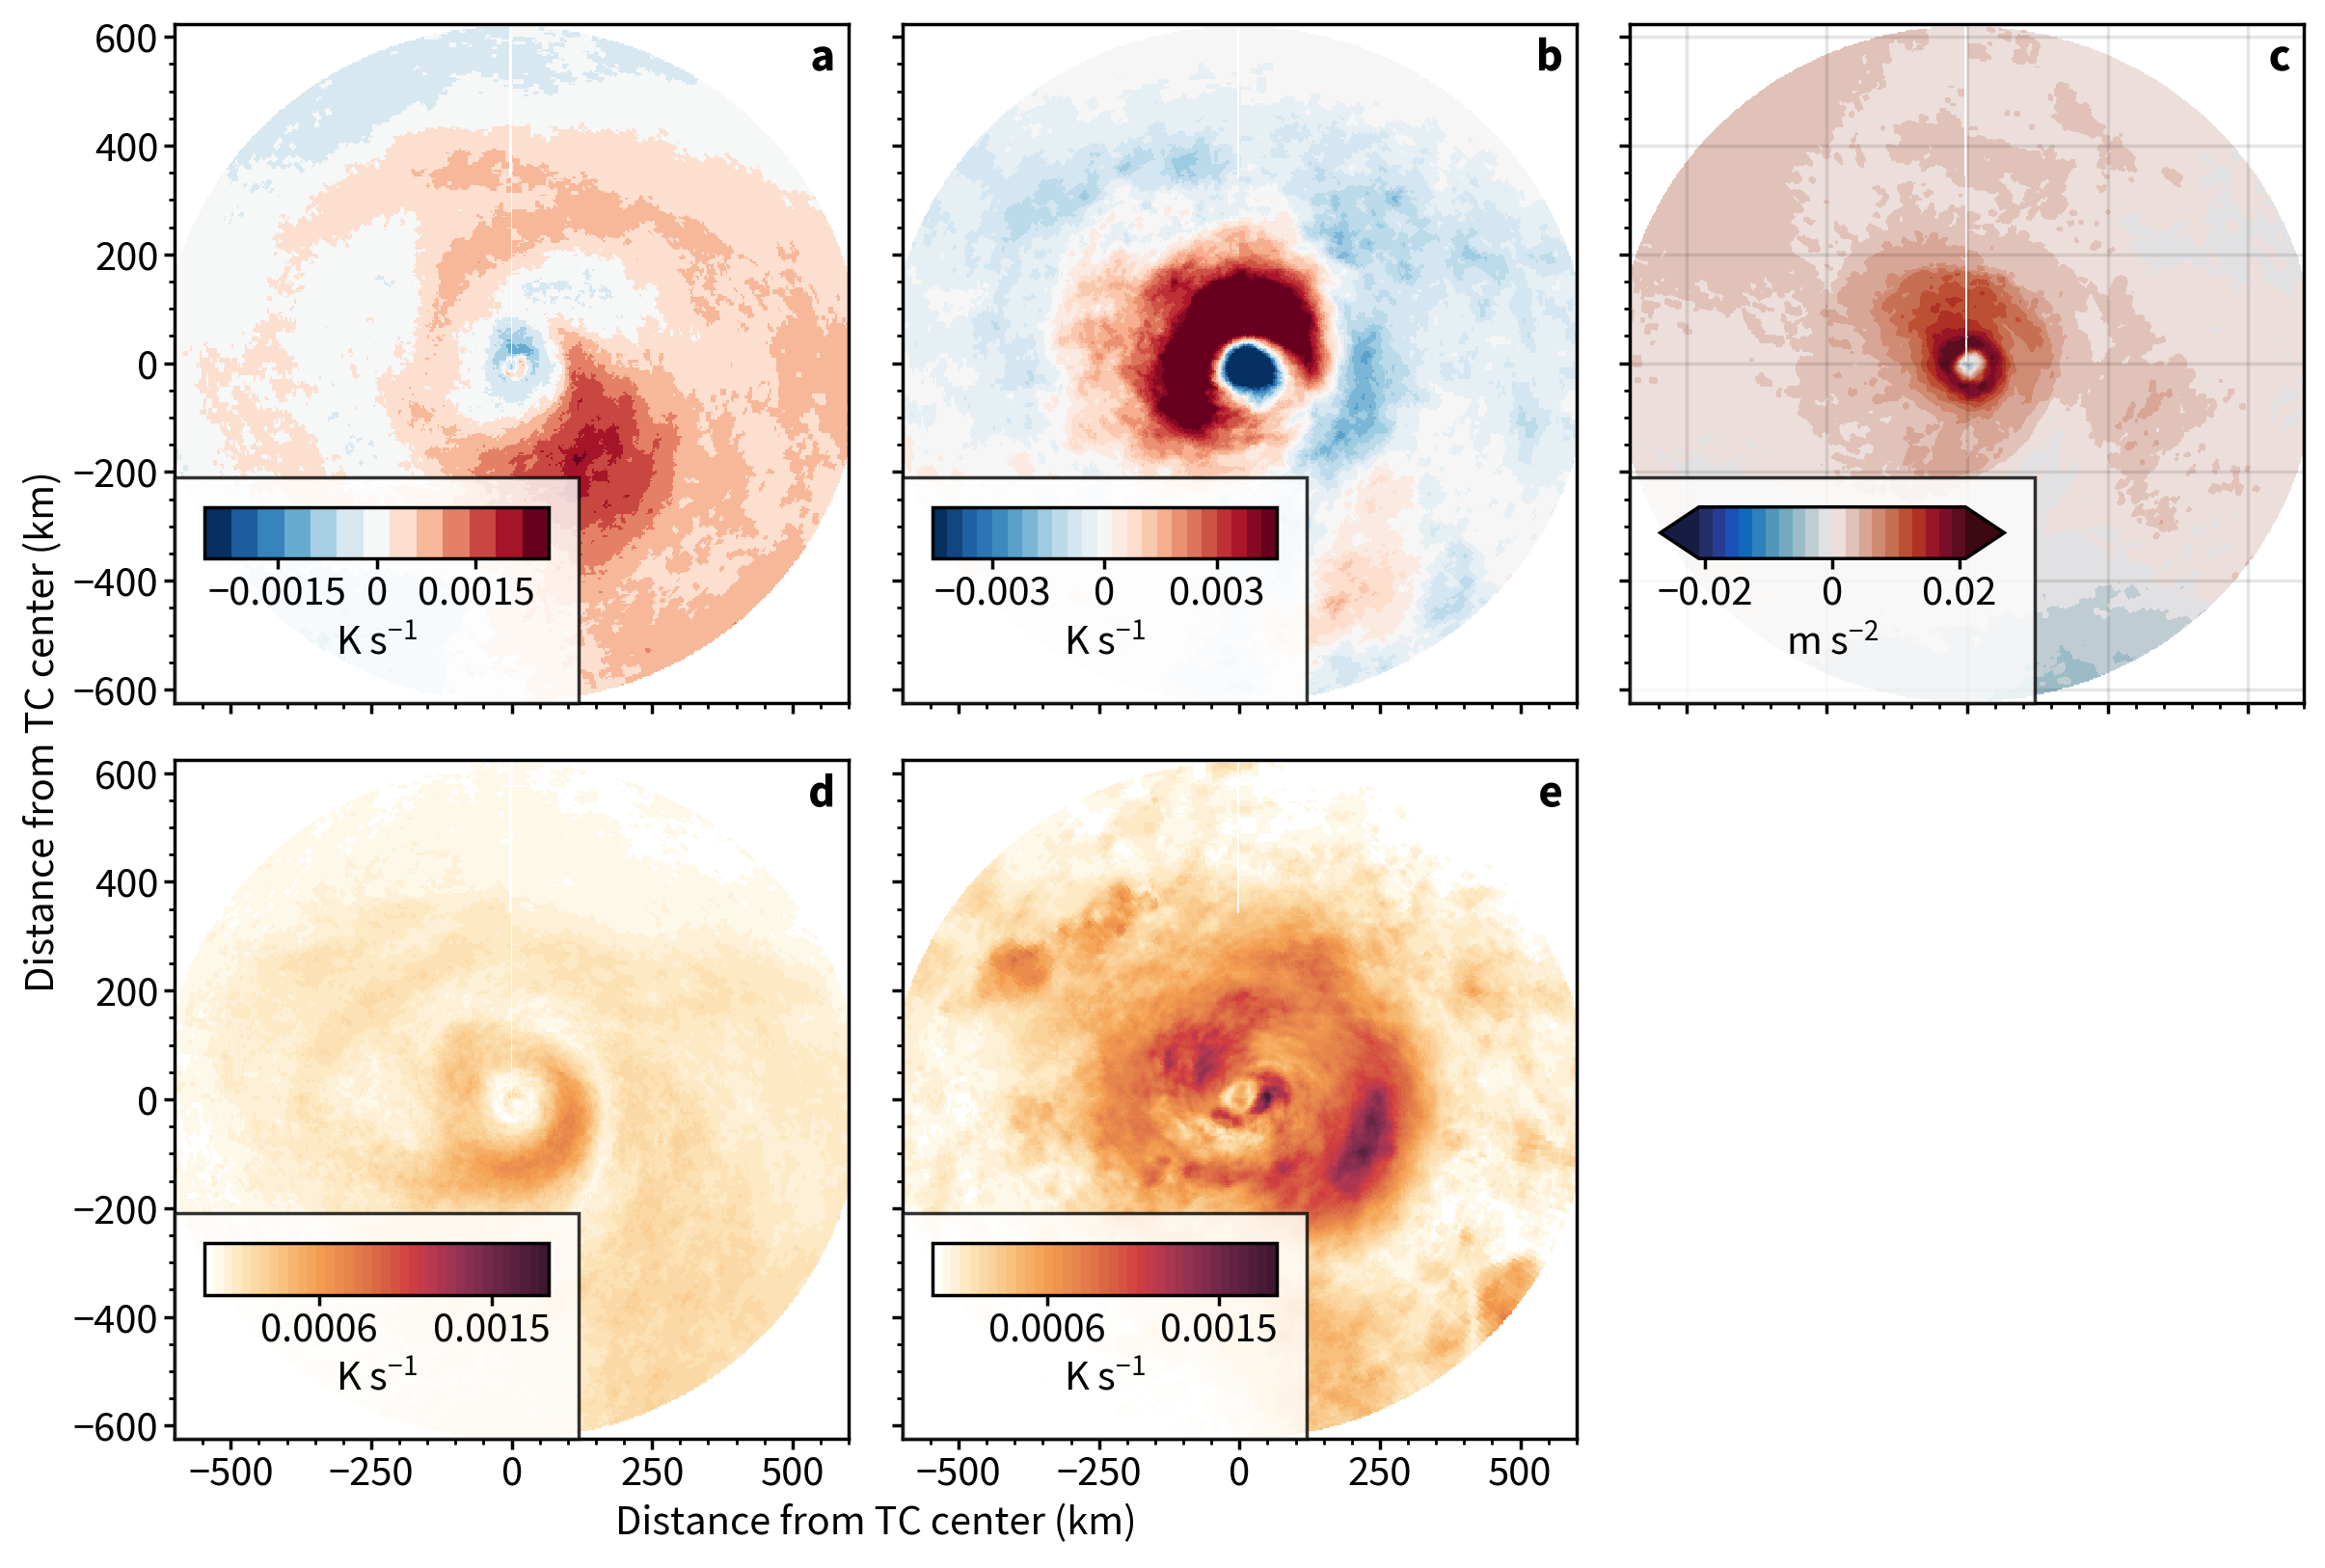

In [33]:
fig,axs = plot.subplots(ncols=3,nrows=2,axwidth=3.495,refaspect=0.9931)

# Plotting the cross section of mean LW structures at 1000 hPa and 100 hPa
for i,obj in enumerate(pressure_indx):
    if i==0:
        levels= np.linspace(-0.0026,0.0026,14)
        ticks = [-0.0015,0,0.0015]
    else:
        levels= np.linspace(-0.0046,0.0046,24)
        ticks = [-0.003,0,0.003]
    apl = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(flas)[obj,...],ANGLE,True,False))))
    values = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(flas)[obj,...],ANGLE,True,False))))[0,0]
    maps = axs[i].pcolormesh(np.linspace(-208,208,417)*3, np.linspace(-208,208,417)*3, np.ma.masked_where(apl==values,apl),cmap='BuRd',levels=levels)
    axs[i].format(xlabel='Distance from TC center (km)', ylabel='Distance from TC center (km)',xlim=[-600,600])
    axs[i].colorbar(maps,loc='ll',ticks=ticks,label='K s$^{-1}$')
    
# Derive the standard deviation map based on the LW mean structures of the 10-best models at 1000 hPa (AAAu) and 100 hPa (AAAu_u)
AAAu = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.std(np.asarray([np.asarray(storeLW[modelranki])[pressure_indx[0],...] for modelranki in range(len(storeLW))]),axis=0),ANGLE,True,False))))
AAAu_u = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.std(np.asarray([np.asarray(storeLW[modelranki])[pressure_indx[1],...] for modelranki in range(len(storeLW))]),axis=0),ANGLE,True,False))))

# Plot the standard deviation maps
maps=axs[3].pcolormesh(np.linspace(-208,208,417)*3, np.linspace(-208,208,417)*3, np.ma.masked_where(AAAu==AAAu[0,0],AAAu),cmap='fire',levels=np.linspace(0,0.0018,38))
axs[3].colorbar(maps,loc='ll',ticks=[0.0006,0.0015],label='K s$^{-1}$')
maps2=axs[4].pcolormesh(np.linspace(-208,208,417)*3, np.linspace(-208,208,417)*3, np.ma.masked_where(AAAu_u==AAAu_u[0,0],AAAu_u),cmap='fire',levels=np.linspace(0,0.0018,38))
axs[4].colorbar(maps2,loc='ll',ticks=[0.0006,0.0015],label='K s$^{-1}$')
axs[3].format(xlabel='Distance from TC center (km)', ylabel='Distance from TC center (km)',xlim=[-600,600])
axs[4].format(xlabel='Distance from TC center (km)', ylabel='Distance from TC center (km)',xlim=[-600,600])

# Plot the surface intensification in 24 hours, starting from Hour 16
wspd = ((haiyan_u[2][140-132+24]**2+haiyan_v[2][16+24]**2)**(0.5)-(haiyan_u[2][16]**2+haiyan_v[2][16]**2)**(0.5))/(60*24)
apl = (np.fliplr(np.flipud(read_and_proc.proc_tocart(wspd.reshape(10,360,208)[0],ANGLE,True,False))))
maps = axs[2].contourf(np.linspace(-208,208,417)*3, np.linspace(-208,208,417)*3,np.ma.masked_where(apl==apl[0,0],apl),cmap='balance',levels=np.linspace(-0.021,0.021,21),extend='both')

axs[2].format(xlabel='Distance from TC center (km)', ylabel='Distance from TC center (km)',xlim=[-600,600])
axs[2].colorbar(maps,loc='ll',ticks=[-0.02,0,0.02],label='m s$^{-2}$')
axs[5].set_visible(False)
axs.format(abc=True,abcloc='ur')

#plt.savefig('./figures/fig4_optimstructures3D_revised_haiyan.png',dpi=600)
plt.show()